# Сборный проект

**Цель исследования:**
1. Изучить воронку продаж.
<br>
2. Анализ результатов A/A/B-эксперимента.

**Ход исследования:**
 1. Подготовка и предобработка данных.
 2. Построение и изучение воронки продаж.
 3. Проверка статистических гипотез

## Шаг 1

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import math as mth
import scipy.stats as st

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep ="\t")

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Шаг 2

In [5]:
#Переименуем названия столбцов
df.rename(columns={'EventName':'event_name', 'DeviceIDHash':'device_id', 'EventTimestamp':'event_dt', 'ExpId':'group'}, inplace = True)

In [6]:
#Изменим тип в колонке с датой и временем
df['event_dt'] = pd.to_datetime(df['event_dt'], unit='s')

In [7]:
#Добавим столбец с датой
df['date'] = pd.DatetimeIndex(df['event_dt']).date

In [8]:
df.duplicated().sum()

413

In [9]:
#Удалим дубликаты
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

event_name    0
device_id     0
event_dt      0
group         0
date          0
dtype: int64

**Проверим есть ли в разных группах одинаковые пользователи** 

In [12]:
if df['device_id'].nunique() == df.groupby('group')['device_id'].nunique().sum():
    print('В разных группах нет одинаковых пользователей')
else:
    print('В разных группах есть одни и те же пользователи')

В разных группах нет одинаковых пользователей


**Проверим изменения**

In [13]:
df.head()

,event_name,device_id,event_dt,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   event_dt    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


**В исходных данных были обнаружены и удалены дубликаты, были переименованы столбцы в соответствии с "хорошим стилем", колонка с датой и временем была приведена к нужному типу, также был добавлен столбец с датой, была проведена проверка попадания пользователей сразу в несколько групп, таковых пользователей не оказалось.**

## Шаг 3

In [15]:
print('Количество событий:', len(df['event_name']))

Количество событий: 243713


In [16]:
print('Количество пользователей:', len(df['device_id'].unique()))

Количество пользователей: 7551


In [17]:
print('Среднее количество событий на пользователей:', round(len(df['event_name'])/len(df['device_id'].unique())))

Среднее количество событий на пользователей: 32


In [18]:
print('Исследуемый период:',df['date'].min(),'-',df['date'].max())

Исследуемый период: 2019-07-25 - 2019-08-07


**Посмотрим на количество событий по датам**

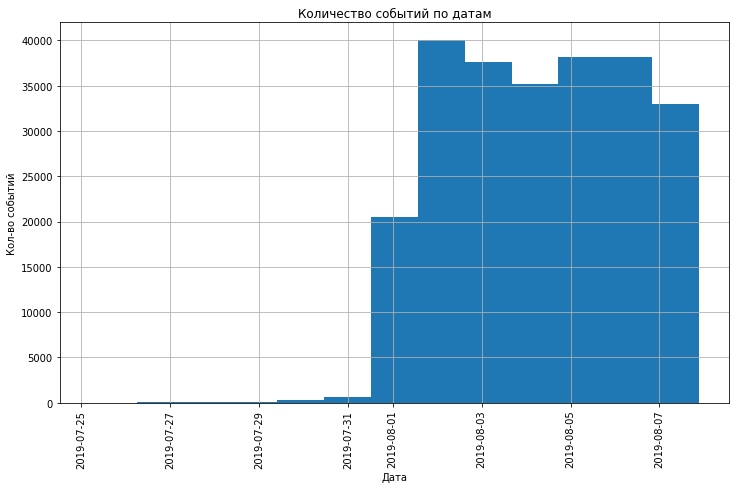

In [19]:
plt.figure(figsize=(12,7))
df['event_dt'].hist(bins=13, grid=True)
plt.title('Количество событий по датам')
plt.xlabel('Дата'), plt.ylabel('Кол-во событий')
plt.xticks(rotation = 90);

In [20]:
df.pivot_table(index='date', values='event_name', aggfunc='count')

,event_name
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


**Из графика и таблицы видно, что данные с 2019-07-25 по 2019-07-31 неполные, посчитаем количество событий в эти даты и отбросим их.**

In [21]:
print('Всего событий до 2019-08-01:',df.query('event_dt<"2019-08-01"')['event_name'].count())
print('Это',str(round((df.query('event_dt<"2019-08-01"')['event_name'].count()/df['event_name'].count()*100),2)) + "%", 'от общего числа')

Всего событий до 2019-08-01: 2826
Это 1.16% от общего числа


In [22]:
user_lost = 0
for user in df.query('event_dt<"2019-08-01"')['device_id'].unique():
    if user not in df.query('event_dt>"2019-08-01"')['device_id'].unique():
        user_lost+=1

In [23]:
print('Всего было потеряно',user_lost,'пользователей')

Всего было потеряно 17 пользователей


In [24]:
#Удалим все события с 2019-07-25 по 2019-07-31, так как их доля незначительна
df = df.query('event_dt>"2019-08-01	"')

**Проверим, остались ли у нас пользователи из всех трех групп**

In [25]:
df.pivot_table(index='group', values='device_id', aggfunc='count')

,device_id
group,
246,79302
247,77022
248,84563


## Шаг 4

In [26]:
df.pivot_table(index='event_name', values='device_id', aggfunc='count').sort_values(by='device_id', ascending=False)

,device_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


**Самым популярным событием является открытие главной страницы, самым непопулярным - обучение.**

In [27]:
print('Количество пользователей, совершивших каждое событие:',int(df.pivot_table(index='device_id', values='event_name', aggfunc='nunique').query('event_name==5').count()))

Количество пользователей, совершивших каждое событие: 466


In [28]:
rate = df.pivot_table(index='event_name', values='device_id', aggfunc='nunique')

In [29]:
rate['rate%'] = rate.values/df['device_id'].nunique()

In [30]:
rate['rate%'] = rate['rate%'].map('{:.2%}'.format)

In [31]:
rate.sort_values(by='rate%', ascending=False)

,device_id,rate%
event_name,,
MainScreenAppear,7419,98.47%
OffersScreenAppear,4593,60.96%
CartScreenAppear,3734,49.56%
PaymentScreenSuccessful,3539,46.97%
Tutorial,840,11.15%


**Почти 98.5% пользователей посещали главную страницу и только 11.15% пользователей проходили обучение. 61% пользователей посетли страницу с товарами, практически 50% перешли на страницу с корзиной и целых 47% перешили на сраницу с успешной оплатой товара.**

**Все события выстраиваются в последовательную цепочку совершения покупки, кроме обучения, поэтому не будем учитывать это событие при расчете воронки.**

In [32]:
voronka = df.query('event_name!="Tutorial"').pivot_table(index='event_name', values='device_id', aggfunc='nunique').sort_values(by='device_id', ascending=False)

In [33]:
voronka['last_event'] = voronka['device_id'].shift(1)

In [34]:
voronka['conversion'] = voronka['device_id']/voronka['last_event']

In [35]:
voronka['conversion'] = voronka['conversion'].map('{:.2%}'.format)

In [36]:
voronka[['device_id','conversion']]

,device_id,conversion
event_name,,
MainScreenAppear,7419,nan%
OffersScreenAppear,4593,61.91%
CartScreenAppear,3734,81.30%
PaymentScreenSuccessful,3539,94.78%


**Из всех пользователей, посетивших главную страницу только 62% переходят на страницу с товарами, из этих пользователей 81.3% перешли на страницу с корзиной и почти 95% из них на страницу с успешной оплатой, то есть наибольшая потеря пользователей происходит на первом шаге.**

In [37]:
print('Только',str(round(voronka['device_id'][3]/voronka['device_id'][0]*100, 1)) + "%",'пользователей доходят от просмотра главной страницы до оплаты товара.')

Только 47.7% пользователей доходят от просмотра главной страницы до оплаты товара.


## Шаг 5

In [38]:
df.pivot_table(index='group', values='device_id', aggfunc='nunique')

,device_id
group,
246,2484
247,2513
248,2537


**В каждой группе примерно по 2500 пользователей.**

**Проверим, находят ли статистические критерии разницу между выборками 246 и 247.**

**Создадим таблицу с воронками по каждой группа, а также функции для проверки гипотез о равенстве долей.**

In [39]:
voronka_by_group = df.pivot_table(index = 'group', columns = 'event_name', values = 'device_id', aggfunc = 'nunique').reset_index()
voronka_by_group['total'] = df.pivot_table(index='group', values='device_id', aggfunc='nunique').values

In [40]:
voronka_by_group

event_name,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537


In [41]:
def z_test(success, trials, alpha):
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [42]:
def automation (group1, group2, alpha):
    alpha_test = alpha
    count_users = ([voronka_by_group['total'][group1], voronka_by_group['total'][group2]])
    count_MainScreenAppear = ([voronka_by_group['MainScreenAppear'][group1], voronka_by_group['MainScreenAppear'][group2]])
    count_OffersScreenAppear = ([voronka_by_group['OffersScreenAppear'][group1], voronka_by_group['OffersScreenAppear'][group2]])
    count_CartScreenAppear = ([voronka_by_group['CartScreenAppear'][group1], voronka_by_group['CartScreenAppear'][group2]])
    count_PaymentScreenSuccessful = ([voronka_by_group['PaymentScreenSuccessful'][group1], voronka_by_group['PaymentScreenSuccessful'][group2]])
    count_Tutorial = ([voronka_by_group['Tutorial'][group1], voronka_by_group['Tutorial'][group2]])
    
    print('Тест для количества людей и события MainScreenAppear')
    z_test(count_MainScreenAppear, count_users, alpha_test)
    
    print('Тест для количества людей и события OffersScreenAppear')
    z_test(count_OffersScreenAppear, count_users, alpha_test)
    
    print('Тест для количества людей и события CartScreenAppear')
    z_test(count_CartScreenAppear, count_users, alpha_test)
    
    print('Тест для количества людей и события PaymentScreenSuccessful')
    z_test(count_PaymentScreenSuccessful, count_users, alpha_test)
    
    print('Тест для количества людей и события Tutorial')
    z_test(count_Tutorial, count_users, alpha_test)

**Применим созданную функцию для проверки разницы между группами 226 и 227.**

Сформулируем гипотезы:<br>
    Нулевая: Доли между группами 226 и 227 равны. <br>
    Альтернативная: доля одной из групп больше или меньше доли другой группы.
    <br>
    Уровень статистической значимости alpha=0.1.

In [43]:
automation (0, 1, 0.1)

Тест для количества людей и события MainScreenAppear
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Статистические критерии не нашли разницу между выборками 246 и 247, тест работает корректно.**

In [44]:
#Добавляем строку с соединенными группами 246 и 247
voronka_by_group.loc['3'] = voronka_by_group.loc[0] + voronka_by_group.loc[1]
voronka_by_group = voronka_by_group.replace([493],'246+247')
voronka_by_group = voronka_by_group.reset_index()
voronka_by_group.drop(columns=voronka_by_group.columns[0], axis= 1 , inplace= True )

In [45]:
voronka_by_group 

event_name,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537
3,246+247,2504,4926,3062,2358,561,4997


**Проведем тест для разных групп**

Гипотезы:<br>
    Нулевая: Доли между группами равны. <br>
    Альтернативная: доля одной из групп больше или меньше доли другой группы.|<br>
    Уровень статистической значимости alpha=0.1.

**Тест для групп 246 и 248:**

In [46]:
automation (0, 2, 0.1)

Тест для количества людей и события MainScreenAppear
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.07842923237520116
Отвергаем нулевую гипотезу: между долями есть значимая разница
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Для групп 246 и 248 есть разница в долях пользователей, открывших страницу с корзиной.**

In [47]:
round(float(voronka_by_group.query('group==246')['CartScreenAppear']/voronka_by_group.query('group==246')['total']), 2)

0.51

In [48]:
round(float(voronka_by_group.query('group==248')['CartScreenAppear']/voronka_by_group.query('group==248')['total']), 2)

0.48

**Разница по долям у этого события между группами 3%**

**Тест для групп 247 и 248:**

In [49]:
automation (1, 2, 0.1)

Тест для количества людей и события MainScreenAppear
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Значимых различий между группами 247 и 248 нет.**

**Тест для объединных групп 246 и 247 и группой 248:**

In [50]:
automation (3, 2, 0.1)

Тест для количества людей и события MainScreenAppear
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Между объединенными 246 и 247 группами и группой 248 также нет значимых различий.**

**Проверим гипотезы с уровнем статистической значимости alpha=0.05.**

**Тест для групп 246 и 247:**

In [51]:
automation (0, 1, 0.05)

Тест для количества людей и события MainScreenAppear
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Тест для групп 246 и 248:**

In [52]:
automation (0, 2, 0.05)

Тест для количества людей и события MainScreenAppear
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Тест для групп 247 и 248:**

In [53]:
automation (1, 2, 0.05)

Тест для количества людей и события MainScreenAppear
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Тест для объединных групп 246 и 247 и группой 248:**

In [54]:
automation (3, 2, 0.05)

Тест для количества людей и события MainScreenAppear
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события OffersScreenAppear
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события CartScreenAppear
p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события PaymentScreenSuccessful
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Тест для количества людей и события Tutorial
p-value:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**При уровне значимаости 0.05 тест показал что для групп 246 и 248 нет разница в долях пользователей, открывших страницу с корзиной, в отличие от теста с уровнем значимости 0.1, все остальные тесты также не выявили значимых различий.**

**Так как мы проводим множественную проверку гипотез, то с кажддой проверкой увеличивается риск ложнопозитивного результата, поэтому более оптимальным уровнем статистической значимости будет 0.05, в отличие от уровня 0.01, так как меньший данный показатель наиболее вероятно исключит ошибку первого рода, то есть будет меньшая вероятность найти значимые различия там, где их быть не должно.**

## Вывод

**В исходных данных были обнаружены и впоследствии удалены дубликаты, названия столбцов были переименованы в соответствии с "хорошим стилем", колонка с датами была приведена к нужному типу, пропусков обнаружено не было, также не были обнаружены пользователи, попавшие в несколько групп.**

**Исследуемый период был с 2019-07-25 по 2019-08-07, но было обнаружено, что в период с 2019-07-25 по 2019-07-31 произошло всего 1.16% событий, поэтому было принято решение не учитывать этот период в исследовании.**

**Самым популярным событием оказалось открытие главной страницы, самым непопулярным - обучение. Всего 466 пользователей совершили каждое событие. Почти 98.5% пользователей посещали главную страницу и только 11.15% пользователей проходили обучение. 61% пользователей посетли страницу с товарами, практически 50% перешли на страницу с корзиной и целых 47% перешили на сраницу с успешной оплатой товара.**

**При расчете воронки продаж не учитывалось событие с прохождением обучения, так как оно не встраивается в последовательную цепочку совершения покупки вместе с остальными событиями. Воронка выглядит следующим образом: пользователь открывает главную сраницу, открывает страницу с товаром, добавляет товар в корзину и открывает ее страницу, далее оплачивает товар и переходит на страницу с успешной оплатой. Из всех пользователей, посетивших главную страницу только 62% переходят на страницу с товарами, из этих пользователей 81.3% перешли на страницу с корзиной и почти 95% из них на страницу с успешной оплатой, то есть наибольшая потеря пользователей происходит на первом шаге. Из всех пользователей 47.7% пользователей доходят от просмотра главной страницы до оплаты товара.**

**В каждой группе около 2500 пользователей. При проведении тестов статистических различий между группами 246 и 247 не было найдено. Тесты проводились с двумя уровнями статистической значимости: alpha=0.1 и alpha=0.05. Все тесты показали, что разницы между группами 246 и 247, 246 и 248, 247 и 248, а также объединенными группами 246 и 247 и группой 248 нет, за исключением проверки групп 246 и 248 с уровенем статистической значимости alpha=0.1, тут тест показал разницу между долями пользователей, открывших страницу с корзиной у этих групп. Как выяснилось в группе 246 процент пользователей, добавивших товар в корзину 51%, а в группе 248 их 48%.**